In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import heapq
import time
import random
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import preprocessing
from sklearn import linear_model
from scipy.stats import rankdata
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib import rc

import scipy.stats

from scipy.integrate import trapz

In [2]:
skip_training = False 

# Concrete Dropout

## Data

The dataset we used is the "Californai Housing Prices", the link is https://www.kaggle.com/camnugent/california-housing-prices

In [3]:
def data_generating(traindf, testdf):
    # training set
    trainx = traindf.drop('median_house_value', axis=1).values
    trainy = traindf['median_house_value'].values
    # test set
    testx = testdf.drop('median_house_value', axis=1).values
    testy = testdf['median_house_value'].values
   
    scalerx = preprocessing.MinMaxScaler().fit(trainx)
    trainx = scalerx.transform(trainx) + 0.5
    testx = scalerx.transform(testx) + 0.5

    scalery = preprocessing.MinMaxScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1)
    testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)
      
    
    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float)
    y = torch.tensor(trainy[0], dtype = torch.float)
    x_test = torch.tensor(testx, dtype = torch.float)
    y_test = torch.tensor(testy[0], dtype = torch.float)
    
    return x, y, x_test, y_test

## Model

In [4]:
class ConcreteDropout(nn.Module):
    def __init__(self, size = 1, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.9):
        
        super(ConcreteDropout, self).__init__()
        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(size).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
            
        out = layer(self._concrete_dropout(x, p))

        sum_of_square = 0
        
        network_weights = torch.sum(torch.sum(torch.pow(layer.weight, 2), 0) / (1 - p))
        network_bias = torch.sum(torch.pow(layer.bias, 2))   
            
        weights_regularizer = self.weight_regularizer * (network_bias + network_weights)

        dropout_regularizer = p * torch.log(p) + (1. - p) * torch.log(1. - p)
        dropout_regularizer = self.dropout_regularizer * torch.sum(dropout_regularizer)

        regularization = weights_regularizer + dropout_regularizer

        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [5]:
class Model_var(nn.Module):
    def __init__(self, weight_regularizer, dropout_regularizer):
        super(Model_var, self).__init__()
        self.linear1 = nn.Linear(8, 50)
        self.linear2 = nn.Linear(50, 50)
        self.linear3 = nn.Linear(50, 20)
        
        
        self.linear4_mu = nn.Linear(20, 1)
        self.linear4_var = nn.Linear(20, 1)
        
        self.conc_drop1 = ConcreteDropout(size = 8, weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(size = 50, weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop3 = ConcreteDropout(size = 50, weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        
        self.conc_drop_mu = ConcreteDropout(size = 20, weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)
        self.conc_drop_logvar = ConcreteDropout(size = 20, weight_regularizer=weight_regularizer,
                                                 dropout_regularizer=dropout_regularizer)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        if self.training:
            regularization = torch.empty(5)

            x1, regularization[0] = self.conc_drop1(x, self.linear1)
            x1 = self.relu(x1)
            x2, regularization[1] = self.conc_drop2(x1, self.linear2)
            x2 = self.relu(x2)
            x3, regularization[2] = self.conc_drop3(x2, self.linear3)
            x3 = self.relu(x3)
            output, regularization[3] = self.conc_drop_mu(x3, self.linear4_mu)
            log_var, regularization[4] = self.conc_drop_mu(x3, self.linear4_var)

            return output, log_var, regularization.sum()
        else:
            x = self.relu(self.linear1(x))
            x = self.relu(self.linear2(x))
            x = self.relu(self.linear3(x))
            x = self.linear4_mu(x)
            return x

def heteroscedastic_loss_var(true, mean, log_var):
    precision = torch.exp(-log_var)
    return torch.mean(torch.sum(precision * (true - mean)**2 + log_var, 1), 0)

In [6]:
class Main_effect(nn.Module):
    def __init__(self, num_dim):
        super(Main_effect, self).__init__()
        self.fc1 = nn.Linear(num_dim, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

In [7]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        if len(val_errors) < self.patience + 1:
            return False
        else:
            current_best = min(val_errors[:-self.patience])
            current_stop = True
            for i in range(self.patience):
                current_stop = current_stop and (val_errors[-i-1] - current_best > self.tolerance)
            return current_stop

## Training

In [8]:
def training_CD_var(mlp, main_effect, x, y, x_test, y_test, learning_rate = 0.001, batch_size = 50, num_epoch=1000, tolerance=0.002, patience = 20):
    
    parameters = set(main_effect.parameters()) | set(mlp.parameters())
    optimizer = optim.Adam(parameters, lr = learning_rate)
    early_stop = EarlyStopping(tolerance, patience)
    criterion = nn.MSELoss()

    train_errors = []
    val_errors = []

    num_data, num_dim = x.shape
    y = y.view(-1, 1)
    data = torch.cat((x, y), 1)

    for epoch in range(num_epoch):
        # permuate the data
        data_perm = data[torch.randperm(len(data))]
        x = data_perm[:, 0:-1]
        y = data_perm[:, -1]

        for index in range(int(num_data/batch_size)):
            # data comes in
            inputs = x[index*batch_size : (index+1)*batch_size]
            labels = y[index*batch_size : (index+1)*batch_size].view(-1,1)

            # initialize the gradient of optimizer
            optimizer.zero_grad()
            mlp.train()
            # calculate the loss function

            output_mlp, var, reg = mlp(inputs)          
            loss = heteroscedastic_loss_var(labels, output_mlp + main_effect(inputs), var) + reg

            # backpropogate the gradient     
            loss.backward()
            # optimize with SGD
            optimizer.step()

        # train and validation loss
        mlp.eval()
        train_errors.append(criterion(mlp.forward(x) + main_effect.forward(x), y.view(-1,1)))
        val_errors.append(criterion(mlp.forward(x_test) + main_effect.forward(x_test), y_test.view(-1,1)))

        # determine if early stop
        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

        if (epoch % 10) == 0:
            print('EPOACH %d: TRAIN LOSS: %.4f; VAL LOSS IS: %.5f.'% (epoch+1, train_errors[epoch], val_errors[epoch]))
        torch.save(mlp.state_dict(), 'CD_mlp_01.pth')
        

## Experiment

In [9]:
# remove none value
df = pd.read_csv("housing.csv", sep=",")
df = df.dropna(axis=0)
# remove ocean_proximity
df = df.drop('ocean_proximity', axis = 1)
# split data into training and test set

np.random.seed(129)
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
testdf = df[~msk]
x, y, x_test, y_test = data_generating(traindf, testdf)
num_data, num_feature = x.shape

In [10]:
l = 1e-4
wr = l**2. / num_data
dr = 2. / num_data
learning_rate = 0.001
batch_size = 50; num_epoch = 1000;
tolerance = 0.01; patience = 20;

In [11]:
mlp_cd_var = Model_var(wr, dr)
main_effect_cd_var = Main_effect(num_feature)

In [12]:
#if skip_training:
    
training_CD_var(mlp_cd_var, main_effect_cd_var, x, y, x_test, y_test, learning_rate, batch_size, num_epoch, tolerance, patience)

EPOACH 1: TRAIN LOSS: 0.0444; VAL LOSS IS: 0.04494.
EPOACH 11: TRAIN LOSS: 0.0239; VAL LOSS IS: 0.02453.
EPOACH 21: TRAIN LOSS: 0.0230; VAL LOSS IS: 0.02377.
EPOACH 31: TRAIN LOSS: 0.0231; VAL LOSS IS: 0.02399.
EPOACH 41: TRAIN LOSS: 0.0223; VAL LOSS IS: 0.02313.
EPOACH 51: TRAIN LOSS: 0.0220; VAL LOSS IS: 0.02290.
EPOACH 61: TRAIN LOSS: 0.0218; VAL LOSS IS: 0.02275.
EPOACH 71: TRAIN LOSS: 0.0216; VAL LOSS IS: 0.02251.
EPOACH 81: TRAIN LOSS: 0.0213; VAL LOSS IS: 0.02219.
EPOACH 91: TRAIN LOSS: 0.0216; VAL LOSS IS: 0.02258.
EPOACH 101: TRAIN LOSS: 0.0218; VAL LOSS IS: 0.02262.
EPOACH 111: TRAIN LOSS: 0.0208; VAL LOSS IS: 0.02170.
EPOACH 121: TRAIN LOSS: 0.0206; VAL LOSS IS: 0.02141.
EPOACH 131: TRAIN LOSS: 0.0206; VAL LOSS IS: 0.02150.
EPOACH 141: TRAIN LOSS: 0.0201; VAL LOSS IS: 0.02091.
EPOACH 151: TRAIN LOSS: 0.0195; VAL LOSS IS: 0.02021.
EPOACH 161: TRAIN LOSS: 0.0185; VAL LOSS IS: 0.01940.
EPOACH 171: TRAIN LOSS: 0.0191; VAL LOSS IS: 0.01976.
EPOACH 181: TRAIN LOSS: 0.0189; VAL LOS

In [17]:
# MC sample 
K_test = 20 # sample 20 times 
mlp_cd_var.train() 
MC_samples = [mlp_cd_var(x_test)[0] + main_effect_cd_var(x_test) for _ in range(K_test)]  
mean_samples = torch.stack([tup for tup in MC_samples]).view(K_test, x_test.shape[0]).cpu().data.numpy()  # shape (20, 4000) 
MC_sample_logvar = [mlp_cd_var(x_test)[1] for _ in range(K_test)]
logvar = torch.stack([tup for tup in MC_sample_logvar]).view(K_test, x_test.shape[0]).cpu().data.numpy() # shape (20, 4000)
var = np.exp(logvar)
var = np.mean(var,0)

for samples in mean_samples:
    for i in range(len(samples)):
        samples[i] = np.random.normal(samples[i], np.sqrt(var[i]))

mean = np.mean(mean_samples, 0) # 4000*1
concrete_uncertainty = np.std(mean_samples, 0)  # 4000*1


the area between two lines is =  -0.017057323293660498


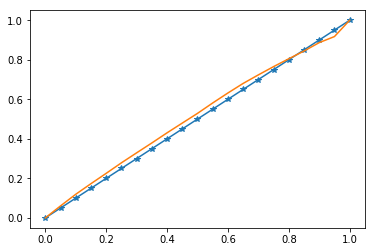

In [20]:
def hit_probability(y_test, mean, concrete_uncertainty, confidence):
    confidence_lower, confidence_higher = scipy.stats.norm.interval(confidence , mean, concrete_uncertainty)
    return np.sum([1 if y_test[i] <= confidence_higher[i] and y_test[i] >= confidence_lower[i] else 0 for i in range(len(y_test))]) / len(y_test)

confidence = np.linspace(0, 1.0, 21, endpoint = True)

#hit = hit_probability(means, y_test, confidence)
plt.plot(confidence, confidence, '-*')
hit_ratio = [hit_probability(y_test, mean, concrete_uncertainty, c) for c in confidence]

area1 = trapz(confidence, dx = 0.05)
area2 = trapz(hit_ratio, dx = 0.05)
print("the area between two lines is = ", area1 - area2)

plt.plot(confidence, hit_ratio )